# Notebook 1 
## Sleep Detection - EDA
In this notebook we:
- load the project data from <b>"sleep_data_120series_7days.csv"</b> file,
- explore the data to see if values are as expected from the description,
- check if we have missing values,
- calculate new feature - "hour",
- calculate correlations and save highly correlated features into a file -> <b>"features_to_exclude.txt"</b>,
- explore the relation of features with target variable.

In [1]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

pl.Config.set_fmt_str_lengths(100)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from helpers import create_rolling_features, concat_in_order, plot_data

## Loading data
- Data is quite large so we use <b>Polars</b> instead of </b>Pandas</b> for major transformations.

In [2]:
train_data_file = 'data/sleep_data_120series_7days.csv'

In [3]:
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
})

In [4]:
df.head()

series_id,step,dt_minute,anglez,enmo,target
str,i64,datetime[μs],i64,i64,i64
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0


#### Do we have any NULLs or NaNs?
- No missing data - after running the checks below we see that our data is complete.

##### Any NaN's?

In [5]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_nan().sum()).transpose(
    include_header=True, header_name="feature",column_names=["nan's"]).filter(pl.col("nan's")>0)

feature,nan's
str,u32


##### Any NULL's?

In [6]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_null().sum()).transpose(
    include_header=True, header_name="feature",column_names=["null's"]).filter(pl.col("null's")>0)

feature,null's
str,u32


#### Do we have 120 series_id's?
- Yes, we do.

In [7]:
df["series_id"].unique().shape

(120,)

### Datetime feature - hour
- Datetime can't be our feature but we can extract hour from it.
- Also on the bar plot below we see that there are hours when sleep occurs with much higher probability (3 or 4 o'clock) that for others (14-17 o'clock).

In [23]:
df = df.with_columns(
    pl.col('dt_minute').dt.hour().cast(pl.UInt8).alias('hour')
)

In [24]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour
str,i64,datetime[μs],i64,i64,i64,u8
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0,15
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0,15
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0,15
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0,15
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0,15


In [25]:
print("Total observations per hour during the day")
df.group_by("hour").agg(pl.col("target").count().alias("observations per hour")).sort(by="hour")

Total observations per hour during the day


hour,observations per hour
u8,u32
0,49800
1,49800
2,49680
3,49740
4,49740
5,49700
6,49680
7,49680
8,49590


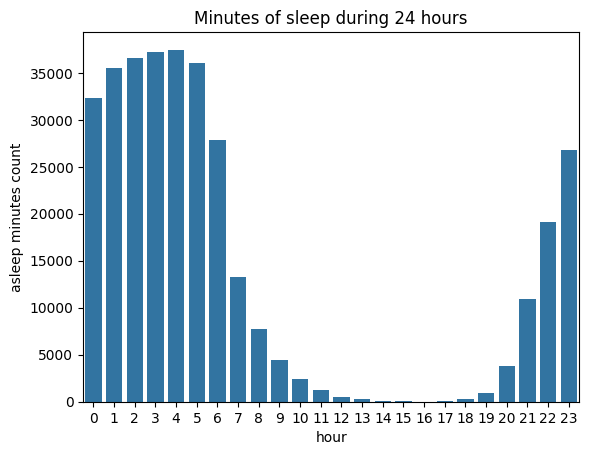

In [26]:
sns.barplot(data=df.group_by("hour").agg((pl.col("target")==1).sum().alias("asleep minutes count")).sort(by="hour"),x="hour",y="asleep minutes count");
plt.title('Minutes of sleep during 24 hours');

In [41]:
def create_sleeping_time_vars(df):
    df = df.with_columns(
        pl.when(pl.col("hour").is_in([22,23,0,1,2,3,4,5,6,7,8]))
        .then(1)
        .otherwise(0)
        .alias('night')
    )
    return df

In [42]:
df = create_sleeping_time_vars(df)

In [43]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,middle_night,low_night,lower_night,night,day
str,i64,datetime[μs],i64,i64,i64,u8,i32,i32,i32,i32,i32
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0,15,0,0,0,0,1
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0,15,0,0,0,0,1
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0,15,0,0,0,0,1
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0,15,0,0,0,0,1
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0,15,0,0,0,0,1


Summary
- <b>"Hour"</b> can be an important feature in modelling the sleep time.

### Basic statistics of features
- There are only numeric features.

In [12]:
features = ["anglez", "enmo", "hour"]

In [13]:
labels = "target"

In [14]:
df.select(features + [labels]).describe()

describe,anglez,enmo,hour,target
str,f64,f64,f64,f64
"""count""",1.193324e6,1.193324e6,1.193324e6,1.193324e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",-7.668257,40.322009,11.504622,0.625447
"""std""",35.099305,76.564596,6.925486,0.761521
"""min""",-90.0,0.0,0.0,0.0
"""25%""",-30.0,2.0,5.0,0.0
"""50%""",-8.0,20.0,12.0,0.0
"""75%""",12.0,46.0,18.0,1.0
"""max""",89.0,2728.0,23.0,2.0


#### Features correlation

In [15]:
features_correlations = (
    df.select(features).corr()
    .with_columns(index = pl.Series(df.select(features).columns))
    .melt(id_vars = "index")
    .filter(pl.col('index') != pl.col('variable'))
)

In [16]:
features_correlations.with_columns(pl.col("value").round(5)).sort(pl.col("value").abs(), descending=True).unique(subset="value")

index,variable,value
str,str,f64
"""hour""","""enmo""",0.15481
"""hour""","""anglez""",0.00561
"""enmo""","""anglez""",0.00719


- Our features are not correlated with each other - which means they provide with a different kind of information.
- We should include them all in the modelling.

#### When did the observations happen?
- Between 2017-08-11 and 2019-05-31.

In [17]:
df.group_by("series_id").agg(
    pl.col("dt_minute").min().alias("start"),
    pl.col("dt_minute").max().alias("end")
).sort(by="start")

series_id,start,end
str,datetime[μs],datetime[μs]
"""5f40907ec171""",2017-08-11 18:15:00,2017-08-18 18:15:00
"""31011ade7c0a""",2017-08-15 16:45:00,2017-08-22 16:45:00
"""78569a801a38""",2017-08-17 16:45:00,2017-08-24 16:45:00
"""0ce74d6d2106""",2017-08-21 16:30:00,2017-08-28 16:30:00
"""3665c86afaf5""",2017-08-21 17:00:00,2017-08-28 17:00:00
"""4ab54be1a403""",2017-08-23 15:30:00,2017-08-30 15:30:00
"""e1f2a4f991cb""",2017-08-29 17:00:00,2017-09-05 17:00:00
"""2fbbee1a38e3""",2017-08-31 12:30:00,2017-09-07 12:30:00
"""51b23d177971""",2017-09-06 12:15:00,2017-09-13 12:15:00


### Target variable
- Our dataset is a bit imbalanced but not too much.
- We need to check if the labels==2 will be there in all train, validation and test sets.
- We can check is adding weights in the model definition help improve the results.

In [18]:
df_labels = df.group_by(labels).agg(
    pl.col("dt_minute").count().alias("count")
)
df_labels.with_columns(frac = (pl.col("count") / df_labels["count"].sum()).round(2))

target,count,frac
i64,u32,f64
0,653200,0.55
1,333887,0.28
2,206237,0.17


## Rolling features
- Our feaures ("anglez" and "enmo") are one minute averages. However, we see on the time plot that longer periods determine sleep state better.
- We will create more features for longer periods rolling windows.

In [19]:
df = create_rolling_features(df)

In [20]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diffs_15m_sum,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diffs_15m_sum,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diffs_60m_sum,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diffs_60m_sum,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diffs_180m_sum,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diffs_180m_sum,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diffs_480m_sum,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diffs_480m_sum,enmo_diffs_sum_div_max_min_15m,anglez_diffs_sum_div_max_min_15m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_180m,anglez_diffs_sum_div_max_min_180m,enmo_diffs_sum_div_max_min_480m,anglez_diffs_sum_div_max_min_480m
str,i64,datetime[μs],i64,i64,i64,u8,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0,15,15.0,21,12,3.505098,1.496026,-51.5,27,-79,42.82189,27.662937,14.0,21,12,2.363516,1.814691,-72.966667,27,-84,24.864437,14.999179,55.766667,485,12,80.277335,69.4788,-52.033333,40,-85,35.137435,11.674958,74.983333,485,7,71.453175,52.853957,-24.658333,48,-85,33.31955,11.134954,0.149603,0.258532,0.181469,0.133921,0.14658,0.092658,0.110342,0.083097
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0,15,14.777778,21,12,3.34581,1.38873,-54.666667,27,-80,41.167341,26.365562,13.967742,21,12,2.330721,1.799106,-73.225806,27,-84,24.489058,14.758633,56.263736,485,12,79.970805,69.164881,-50.956044,46,-85,36.421578,11.609415,74.80083,485,7,71.360424,52.785473,-24.443983,48,-85,33.416157,11.220945,0.138873,0.244126,0.179911,0.131774,0.145917,0.08795,0.110199,0.083738
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0,15,14.5,21,12,3.27448,1.301708,-57.2,27,-80,39.631076,25.268558,14.0,21,12,2.30007,1.773763,-73.5,27,-84,24.140717,14.529244,56.26087,485,12,79.530196,68.791621,-49.945652,46,-85,37.495015,11.548179,74.595041,485,7,71.284141,52.707502,-24.136364,50,-85,33.688375,11.229315,0.130171,0.233968,0.177376,0.129725,0.14513,0.087486,0.110037,0.082568
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0,15,14.272727,21,12,3.196589,1.286684,-59.181818,27,-80,38.167573,24.212256,14.030303,21,12,2.270529,1.759765,-73.757576,27,-84,23.806551,14.319933,56.580645,485,12,79.156878,68.413245,-48.892473,48,-85,38.649052,11.484758,74.349794,485,7,71.239361,52.621494,-23.843621,50,-85,33.927003,11.214896,0.128668,0.224188,0.175977,0.127857,0.144332,0.085707,0.109857,0.082462
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0,15,14.083333,21,12,3.117643,1.264911,-60.916667,27,-80,36.884237,23.267222,14.029412,21,12,2.235869,1.732597,-74.029412,27,-84,23.496596,14.110025,57.0,485,12,78.835067,68.081536,-48.148936,48,-85,39.110804,11.615419,74.20082,485,7,71.130702,52.517697,-23.659836,50,-85,33.978616,11.239129,0.126491,0.215437,0.17326,0.125982,0.143632,0.086682,0.10964,0.082641


### Correlations
- We have many features so some of them may be highly correlated.
- We want to exclude thos that are correlated with another with coefficient equals 0.85 or higher.
- This is because those features don't bring any new information, slow down computation and make the interpretation of the model more difficult. Specifically, features importance values are not meaningful as correlated features may split importance betweem themselves showing low single importances.

In [37]:
df_numeric = df.drop([
    "series_id",
    "dt_minute",
    "step",
    "target"
])

features_correlations = (
    df_numeric.corr()
    .with_columns(index = pl.Series(df.select(df_numeric.columns).columns))
    .melt(id_vars = "index")
    .filter(pl.col('index') != pl.col('variable'))
)

features_correlations = features_correlations.with_columns([
    pl.struct(["index", "variable"]).map_elements(concat_in_order).alias("vars_pair")
]).unique(subset=["vars_pair"]).sort(pl.col("value").abs(), descending=True).select("index","variable","value")

In [38]:
features_correlations.with_columns(pl.col("value").round(2)).head(25)

index,variable,value
str,str,f64
"""enmo_15m_std""","""enmo_15m_max""",0.98
"""enmo_diffs_60m_sum""","""enmo_60m_max""",0.97
"""enmo_diffs_180m_sum""","""enmo_180m_max""",0.96
"""enmo_60m_std""","""enmo_60m_max""",0.96
"""enmo_diffs_15m_sum""","""enmo_15m_max""",0.95
"""enmo_diffs_180m_sum""","""enmo_180m_std""",0.95
"""enmo_diffs_480m_sum""","""enmo_480m_std""",0.95
"""enmo_diffs_60m_sum""","""enmo_60m_std""",0.95
"""enmo_diffs_15m_sum""","""enmo_15m_std""",0.95


We don't need both features from highly correlated features pair.

In [42]:
correlated_features = [
    "enmo_15m_max","enmo_60m_max","enmo_180m_max","enmo_480m_max",
    "enmo_diffs_15m_sum","enmo_diffs_60m_sum","enmo_diffs_180m_sum","enmo_diffs_480m_sum",
    "anglez","anglez_15m_mean","anglez_15m_std","anglez_diffs_180m_sum",
    "enmo_15m_mean","enmo_60m_mean","enmo_60m_mean","enmo_180m_mean","enmo_480m_mean"
]

In [43]:
with open(r'data/features_to_exclude.txt', 'w') as fp:
    fp.write('\n'.join(correlated_features))

In [44]:
features_correlations.filter(~(pl.col("index").is_in(correlated_features)|pl.col("variable").is_in(correlated_features))) \
    .with_columns(pl.col("value").round(6)).sort(pl.col("value").abs(), descending=True).head(15)

index,variable,value
str,str,f64
"""anglez_480m_mean""","""anglez_180m_mean""",0.839802
"""anglez_180m_mean""","""anglez_60m_mean""",0.837578
"""anglez_480m_std""","""anglez_180m_std""",0.82542
"""enmo_180m_std""","""enmo_60m_std""",0.823734
"""enmo_480m_std""","""enmo_180m_std""",0.822542
"""anglez_diffs_sum_div_max_min_480m""","""anglez_diffs_480m_sum""",0.795475
"""enmo_60m_std""","""enmo_15m_std""",0.779732
"""anglez_60m_mean""","""anglez_15m_max""",0.751877
"""anglez_60m_mean""","""anglez_15m_min""",0.746964


Now we don't have any correlation higher than 0.85.

### Features and target relation
- Our target variable is categorical so we need to analyze it other way than wih correlation.
- Below, we plot histograms for a few variablles.
- We can see some of them clearly discriminate between different values of target variable.

In [45]:
def plot_histogram(var, time, stat):
    not_wear = df.filter((pl.col(labels)==2))[f"{var}_{time}m_{stat}"]
    asleep = df.filter((pl.col(labels)==1))[f"{var}_{time}m_{stat}"]
    awake = df.filter((pl.col(labels)==0))[f"{var}_{time}m_{stat}"]

    sns.set(style="darkgrid")    
    sns.histplot(data=awake, bins = 80, color="teal", label=f"Awake {var} {time} {stat}", kde=True)
    sns.histplot(data=asleep, bins = 80, color="gold", label=f"Asleep {var} {time} {stat}", kde=True, alpha=0.7)
    sns.histplot(data=not_wear, bins = 80, color="olive", label=f"Not-wear {var} {time} {stat}", kde=True)
    
    plt.legend() 
    plt.show()

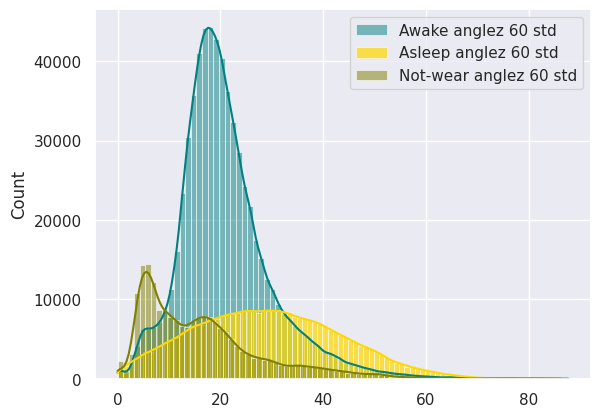

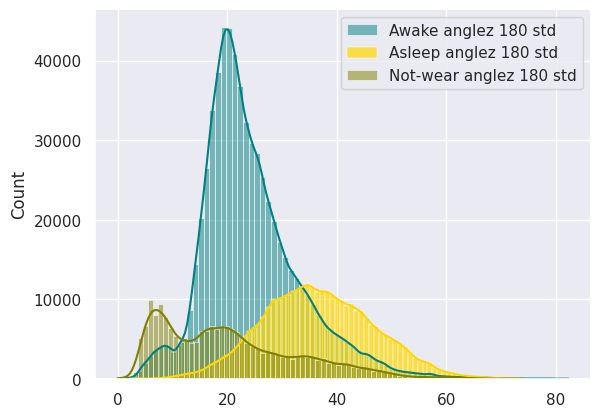

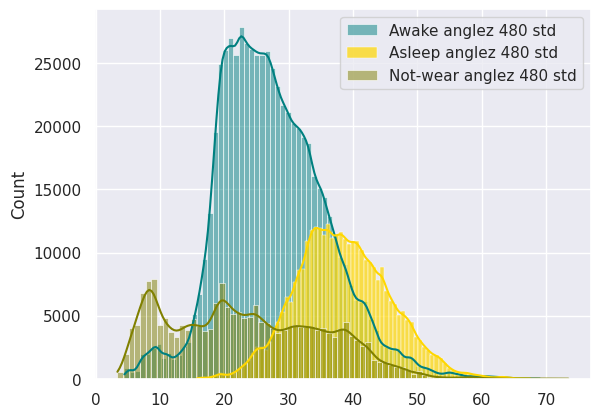

In [47]:
vars = ["anglez"]*4
times = [60, 60*3, 60*8]
stats = ["std"]*4
for var, time, stat in zip(vars, times, stats):
    plot_histogram(var, time, stat)

Summary
- With standard deviation of "enmo" feature we can distinct awake from other states.

## Time plots
Below are plotted two out of 120 series from our dataset.

038441c925bb


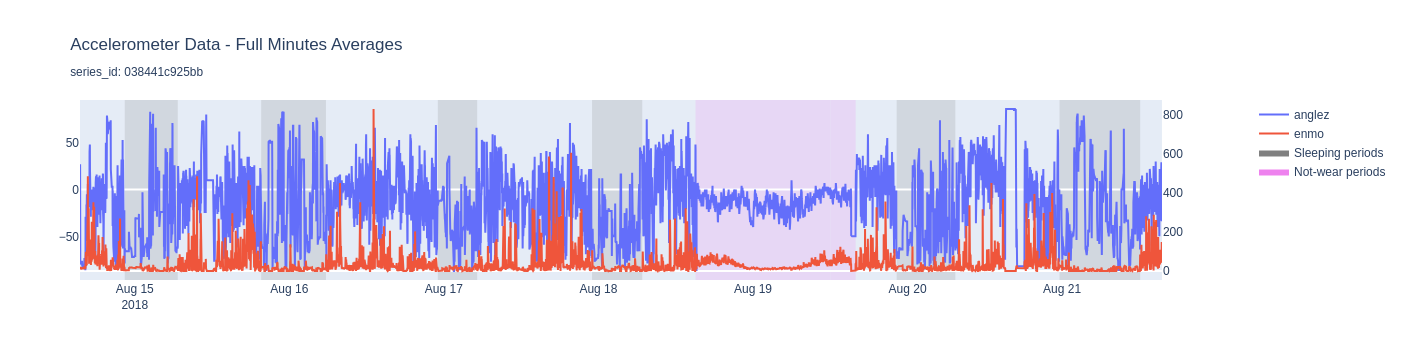

In [12]:
plot_data(df, idx=df["series_id"].unique().sort()[0])

03d92c9f6f8a


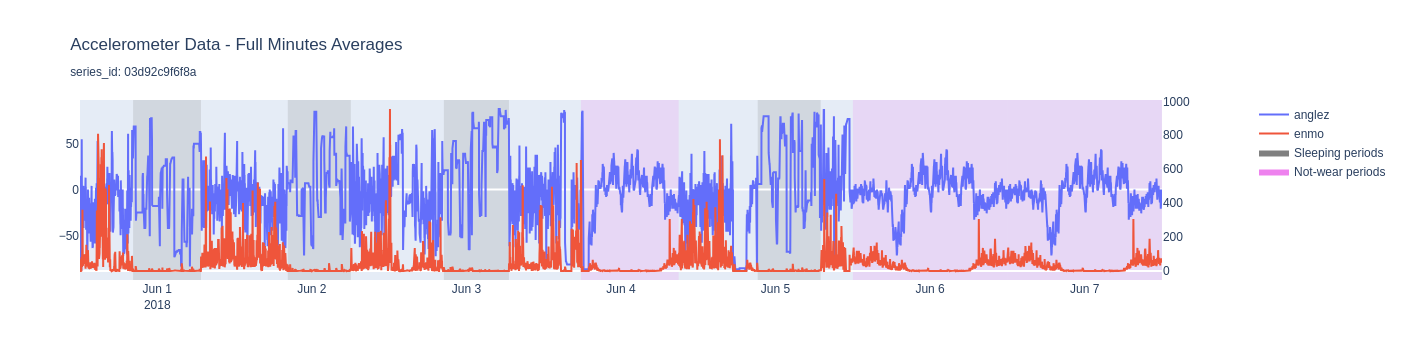

In [13]:
plot_data(df, idx=df["series_id"].unique().sort()[1])

#### We are ready to train a model!
- Let's move on to <b>"model_training.ipynb"</b> notebook.